# Information Density

## TF-IDF weights

At first, I used the **per-token** metric. However, I think that **per-sentence** is important as well. Now I combine both.

| Metric Type     | Use When...                                                                 |
|------------------|------------------------------------------------------------------------------|
| **Per-token**     | Care about **lexical richness** — how informative each word is         |
|                  | Comparing **writing styles** across people or proficiency levels     |
|                  | Analyzing **vocabulary density** or term rarity                      |
| **Per-sentence**  | Want to measure **conciseness** or verbosity per unit of thought       |
|                  | Eevaluating **how much is said per sentence**                         |
|                  | Focusing on **sentence structure**, e.g., for education or summaries |



In [2]:
import json
import re
from html import unescape
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk

nltk.download("punkt")

# Clean HTML/text
def clean_text(html_text):
    text = unescape(html_text)
    text = re.sub(r"<[^>]+>", "", text)
    text = text.replace("\xa0", " ").strip()
    return text

# Compute Information Density
def compute_information_density_metrics(text):
    sentences = nltk.sent_tokenize(text)
    if not sentences:
        return 0.0

    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)

    total_info = tfidf_matrix.sum()
    total_tokens = tfidf_matrix.nnz  # number of non-zero weights (i.e. informative tokens)

    per_token_density = float(total_info / total_tokens)
    per_sentence_density = float(total_info / len(sentences))

    return per_token_density, per_sentence_density


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from sklearn.preprocessing import MinMaxScaler
with open("data_stories_summary.json", "r", encoding="utf-8") as f:
    data = json.load(f)

density_results = []

for story_id, story in data.items():
    raw_texts = story.get("texts", [])
    cleaned_texts = [clean_text(t) for t in raw_texts]
    full_text = " ".join(cleaned_texts)

    if full_text.strip():
        per_token, per_sentence = compute_information_density_metrics(full_text)
    else:
        per_token, per_sentence = 0.0, 0.0

    density_results.append({
        "story_id": story_id,
        "info_density_token": per_token,
        "info_density_sentence": per_sentence
    })

df_density = pd.DataFrame(density_results)
scaler = MinMaxScaler()
df_density[["token_norm", "sentence_norm"]] = scaler.fit_transform(
    df_density[["info_density_token", "info_density_sentence"]]
)
df_density["information_density"] = (
    0.4 * df_density["token_norm"] + 0.6 * df_density["sentence_norm"]
)
df_density.to_csv("outputs/information_density.csv")

print(df_density)


    story_id  info_density_token  info_density_sentence  token_norm  \
0   D-hp3wDV            0.272609               3.472177    0.799237   
1   y4Srva15            0.313834               3.033724    0.920100   
2   7qpfziir            0.301631               2.959752    0.884324   
3   Nokx0yU6            0.301749               3.218657    0.884671   
4   gz_gxhYn            0.252586               3.466048    0.740535   
5   U2OtB3XT            0.306959               2.835715    0.899945   
6   v4h_GSI0            0.272328               3.267936    0.798414   
7   1ptR3pru            0.319796               2.878167    0.937582   
8   JQpdcw-d            0.282679               3.098995    0.828760   
9   B9SLlUry            0.336225               2.833896    0.985747   
10  r7i-PG2n            0.240919               3.225639    0.706329   
11  AUmcnOzL            0.288580               3.339281    0.846061   
12  tyK82z37            0.278919               3.347029    0.817738   
13  IR

## Correlation Info Density X SPARQL Profiency

In [4]:
import pandas as pd

df_density = pd.read_csv('outputs/information_density.csv', index_col=0)
df_sparql = pd.read_csv('outputs/sparql_proficiency_new.csv', index_col=0) # using new SPARQL proficiency with many features (can be changed to sparql_proficiency.csv to see the difference)
df_alternation = pd.read_csv('outputs/alternation_scores.csv', index_col=0)

df_temp = pd.merge(df_density[['story_id', 'information_density']],
                       df_sparql[['story_id', 'sparql_proficiency']],
                       on='story_id', how='inner')

df_combined = pd.merge(
    df_temp,
    df_alternation[['story_id', 'alternation_score']],
    on='story_id',
    how='inner'
)

story_no_text = ['SXefpzf4', 'EzsIH_Et', '6yGct8pP']

df_filtered = df_combined[~df_combined['story_id'].isin(story_no_text)]

print(df_filtered)


    story_id  information_density  sparql_proficiency  alternation_score
0   D-hp3wDV             0.790355            0.419361           0.700000
1   y4Srva15             0.779267            0.293553           0.400000
2   7qpfziir             0.754929            0.344963           0.928571
3   Nokx0yU6             0.790163            0.228978           0.666667
4   gz_gxhYn             0.766043            0.337006           0.928571
5   U2OtB3XT             0.744364            0.366358           0.928571
6   v4h_GSI0             0.762340            0.311218           0.800000
7   1ptR3pru             0.765173            0.289714           0.250000
8   JQpdcw-d             0.751578            0.280591           0.882353
9   B9SLlUry             0.778439            0.375198           0.428571
10  r7i-PG2n             0.719773            0.576555           0.846154
11  AUmcnOzL             0.791070            0.470986           0.888889
12  tyK82z37             0.780791            0.2439

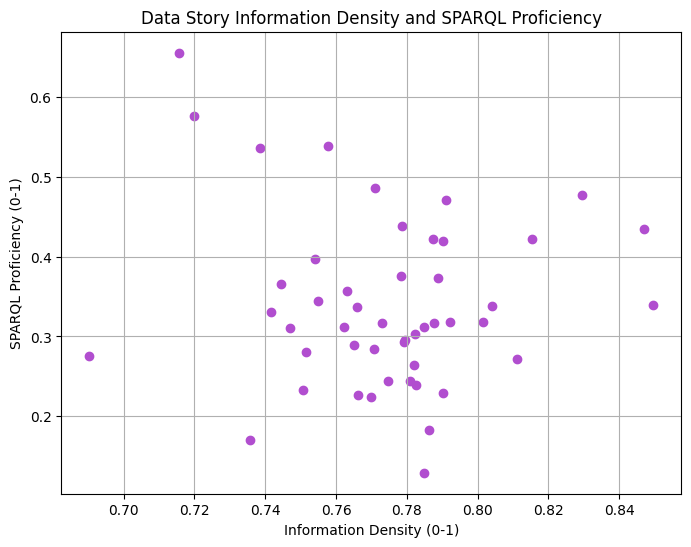

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['information_density'], df_filtered['sparql_proficiency'], color='#b14ecf')
plt.xlabel("Information Density (0-1)")
plt.ylabel("SPARQL Proficiency (0-1)")
plt.title("Data Story Information Density and SPARQL Proficiency")
plt.grid(True)
plt.show()

In [6]:
from scipy.stats import pearsonr, spearmanr

# Pearson (with p-values)
pearson_corr, pearson_p = pearsonr(df_filtered['information_density'], df_filtered['sparql_proficiency'])

# Spearman (with p-values)
spearman_corr, spearman_p = spearmanr(df_filtered['information_density'], df_filtered['sparql_proficiency'])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: -0.096 (p-value: 0.518)
Spearman correlation: 0.018 (p-value: 0.902)


<!-- - No clear relationship — and maybe a slight trend that denser (jargon-heavy?) texts are written by less SPARQL-confident participants.
- Could mean that some students compensate with verbose or content-dense text when they’re less confident with querying.
- non scrivono tanto testo quindi cercano di sintetizzare. -->

Info density and SPARQL proficiency are completely uncorrelated.
People who are good at SPARQL do not necessarily make stories with more or less dense information.

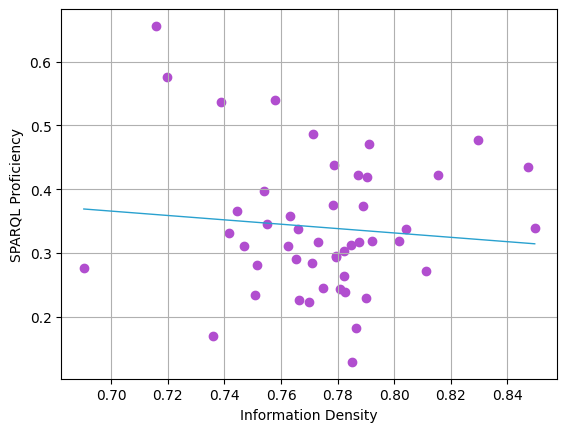

In [7]:
import numpy as np
 
# Sample data
x = np.array(df_filtered['information_density'])
y = np.array(df_filtered['sparql_proficiency'])
 
# Compute best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # 1st-degree polynomial (y = mx + b)
 
# Create scatter plot
plt.scatter(x, y, color='#b14ecf', label="Data points")
 
# Plot best-fit line
x_sorted = np.sort(x)
plt.plot(x_sorted, m*x_sorted + b, color='#29a1cf', linewidth=1, label="Best-fit line")
 
# Labels and title
plt.xlabel("Information Density")
plt.ylabel("SPARQL Proficiency")
plt.grid(True)
plt.show()

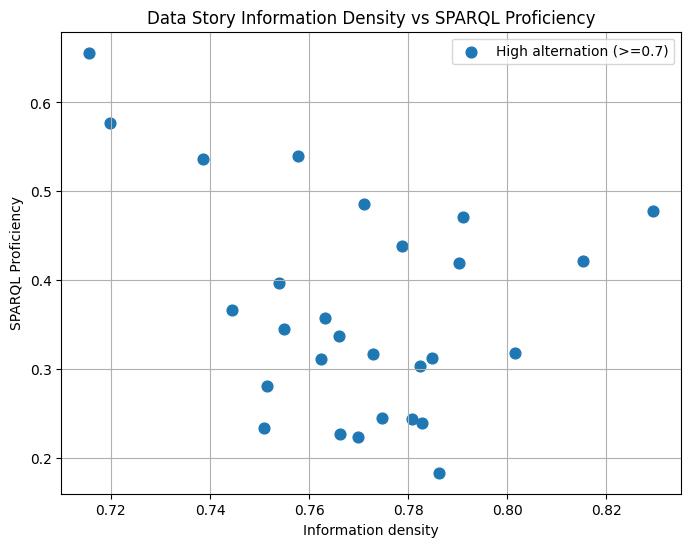

In [9]:
# Create a boolean mask: True if alternation_score > 0.7, else False
high_alternation = df_filtered['alternation_score'] >= 0.7

plt.figure(figsize=(8, 6))

# Plot points with high alternation score
plt.scatter(
    df_filtered.loc[high_alternation, 'information_density'],  # x-values
    df_filtered.loc[high_alternation, 'sparql_proficiency'],      # y-values
    label='High alternation (>=0.7)', 
    marker='o',  # shape of points
    s=60  # size of points
)


plt.xlabel('Information density')
plt.ylabel('SPARQL Proficiency')
plt.title('Data Story Information Density vs SPARQL Proficiency')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from scipy.stats import pearsonr, spearmanr

df_high = df_filtered[high_alternation]

x = df_high['information_density']
y = df_high['sparql_proficiency']

# Pearson correlation
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman correlation
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: -0.307 (p-value: 0.112)
Spearman correlation: -0.198 (p-value: 0.312)


Among high alternation stories, there’s a hint that users with higher SPARQL proficiency may tend to create less dense stories. But evidence is weak, and results are not statistically significant. Pearson is showing more of a possible trend than Spearman — this may indicate that the relationship is linear, but not strong or consistent across ranks.

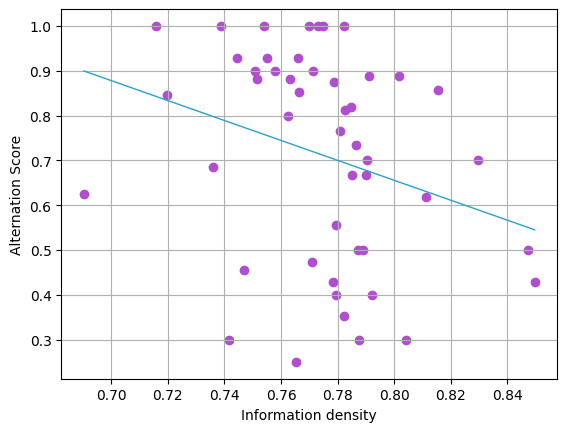

In [11]:
x = np.array(df_filtered['information_density'])
y = np.array(df_filtered['alternation_score'])
 
# Compute best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # 1st-degree polynomial (y = mx + b)
 
# Create scatter plot
plt.scatter(x, y, color='#b14ecf', label="Data points")
 
# Plot best-fit line
x_sorted = np.sort(x)
plt.plot(x_sorted, m*x_sorted + b, color='#29a1cf', linewidth=1, label="Best-fit line")
 
# Labels and title
plt.xlabel("Information density")
plt.ylabel("Alternation Score")
plt.grid(True)
plt.show()

In [12]:
# Pearson correlation
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman correlation
spearman_corr, spearman_p = spearmanr(x, y)

# Print results
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: -0.286 (p-value: 0.048)
Spearman correlation: -0.352 (p-value: 0.014)
